# Policy Gradient


#### This version implements Policy Gradient using a custom enviroment (Unit 4)

In [ ]:
!pip install talib-binary
!pip install yfinance

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

import gym
from gym import spaces
from gym.utils import seeding
from gym import wrappers

from tqdm.notebook import tqdm
from collections import deque
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import talib as ta
import yfinance as yf
import pandas as pd

import io
import base64
from IPython.display import HTML, Video


In [45]:
# custom model to be able to run a custom loss with parameters
class CustomModel(tf.keras.Model):
    def custom_loss(self,y, y_pred, d_returns):
        log_like = y * K.log(y_pred)
        # K.print_tensor(d_returns)
        return K.sum(-log_like * d_returns )
        
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data

        # check if we passed the d_return
        if isinstance(x, tuple):
            x, d_return = x

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            y = tf.cast(y, tf.float32)
            loss = self.custom_loss(y, y_pred, d_return)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        # Metrics are configured in `compile()`.
        self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

In [46]:
class Policy:
    def __init__(self, env=None, action_size=2):

        self.action_size = action_size

        # Hyperparameters
        self.gamma = 0.95           # Discount rate

        self.learning_rate = 1e-3
        
        # Construct DQN models
        self.env = env
        self.action_size = action_size
        self.action_space = [i for i in range(action_size)]
        print("action space",self.action_space)
        # self.saved_log_probs = None
        self.model= self._build_model()
        self.model.summary()


    def _build_model(self):
        x = Input(shape=(4,), name='x_input')
        # y_true = Input( shape=(2,), name='y_true' )
        d_returns = Input(shape=[1], name='d_returns')

        l = layers.Dense(16, activation = 'relu')(x)
        l = layers.Dense(16, activation = 'relu')(l)
        y_pred = layers.Dense(self.action_size, activation = 'softmax', name='y_pred')(l)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        # model_train = Model( inputs=[x], outputs=[y_pred], name='train_only' )
        model_train = CustomModel( inputs=x, outputs=y_pred, name='train_only' )
        # model_predict = Model( inputs=x, outputs=y_pred, name='predict_only' )
        model_train.compile(loss=None, optimizer=optimizer, metrics = ['accuracy'])
        # use run_eagerly to print values inside the loss function to debug
        # model_train.compile(loss=None, optimizer=optimizer, metrics = ['accuracy'], run_eagerly = True)

        return model_train

    def act(self, state):
        probs = self.model.predict(np.array([state]), verbose=0)[0]
        action = np.random.choice(self.action_space, p=probs)

        return action

    # this implements the reinforce 
    def learn(self, n_training_episodes=None, max_t=None, print_every=100):
        # Help us to calculate the score during the training
        scores_deque = deque(maxlen=100)
        scores = []
        # Line 3 of pseudocode
        for i_episode in range(1, n_training_episodes+1):
            # saved_log_probs = []
            saved_actions = []
            saved_state = []
            rewards = []
            state = self.env.reset()
            # Line 4 of pseudocode
            for t in range(max_t):
                saved_state.append(state)
                action = self.act(state)
                # action, log_prob = self.act(state)
                # saved_log_probs.append(log_prob)
                saved_actions.append(action)
                state, reward, done, _ = self.env.step(action)
                rewards.append(reward)
                if done:
                    break 
            scores_deque.append(sum(rewards))
            scores.append(sum(rewards))
            
            # Line 6 of pseudocode: calculate the return
            returns = deque(maxlen=max_t) 
            n_steps = len(rewards) 
            # Compute the discounted returns at each timestep,
            # as 
            #      the sum of the gamma-discounted return at time t (G_t) + the reward at time t
            #
            # In O(N) time, where N is the number of time steps
            # (this definition of the discounted return G_t follows the definition of this quantity 
            # shown at page 44 of Sutton&Barto 2017 2nd draft)
            # G_t = r_(t+1) + r_(t+2) + ...
            
            # Given this formulation, the returns at each timestep t can be computed 
            # by re-using the computed future returns G_(t+1) to compute the current return G_t
            # G_t = r_(t+1) + gamma*G_(t+1)
            # G_(t-1) = r_t + gamma* G_t
            # (this follows a dynamic programming approach, with which we memorize solutions in order 
            # to avoid computing them multiple times)
            
            # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
            # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...
            
            
            ## Given the above, we calculate the returns at timestep t as: 
            #               gamma[t] * return[t] + reward[t]
            #
            ## We compute this starting from the last timestep to the first, in order
            ## to employ the formula presented above and avoid redundant computations that would be needed 
            ## if we were to do it from first to last.
            
            ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
            ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
            ## a normal python list would instead require O(N) to do this.
            for t in range(n_steps)[::-1]:
                disc_return_t = (returns[0] if len(returns)>0 else 0)
                returns.appendleft( self.gamma*disc_return_t + rewards[t]   )    
                
            ## standardization of the returns is employed to make training more stable
            eps = np.finfo(np.float32).eps.item()
            ## eps is the smallest representable float, which is 
            # added to the standard deviation of the returns to avoid numerical instabilities        
            returns = np.array(returns)
            returns = (returns - returns.mean()) / (returns.std() + eps)
            # self.saved_log_probs = saved_log_probs
            
            # Line 7:
            saved_state = np.array(saved_state)
            # print("Saved state", saved_state, saved_state.shape)
            saved_actions = np.array(to_categorical(saved_actions, num_classes=self.action_size))
            # print("Saved actions", saved_actions, saved_actions.shape)
            returns = returns.reshape(-1,1)
            # print("Returns", returns, returns.shape)
            # this is the trick part, we send a tuple so the CustomModel is able to split the x  and use 
            # the returns inside to calculate the custom loss
            self.model.train_on_batch(x=(saved_state,returns), y=saved_actions)

            # policy_loss = []
            # for action, log_prob, disc_return in zip(saved_actions, saved_log_probs, returns):
            #     policy_loss.append(-log_prob * disc_return)
            # policy_loss = torch.cat(policy_loss).sum()
            
            # # Line 8: PyTorch prefers gradient descent 
            # optimizer.zero_grad()
            # policy_loss.backward()
            # optimizer.step()
            
            if i_episode % print_every == 0:
                print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        return scores


    #
    # Loads a saved model
    #
    def load(self, name):
        self.model = tf.keras.models.load_model(name)
        # self.scaler = joblib.load(name+".scaler") 

    #
    # Saves parameters of a trained model
    #
    def save(self, name):
        self.model.save(name)
        # joblib.dump(self.scaler, name+".scaler") 

    def play(self, state):
        # state = self._get_scaled_state(state)
        return np.argmax(self.model.predict(np.array([state]), verbose=0)[0])

In [47]:
from enum import Enum
class Actions(Enum):
    Sell = 0
    Buy = 1
    Do_nothing = 2

class CustTradingEnv(gym.Env):

    def __init__(self, df, max_steps=0, seed=8, random_start=True, scaler=None):
        self.seed(seed=seed)
        self.df = df
        if scaler is None:
            self.scaler = MinMaxScaler()
        else:
            self.scaler = scaler
        self.prices, self.signal_features = self._process_data()

        # spaces
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,) , dtype=np.float64)

        # episode
        self._start_tick = 0
        self._end_tick = 0
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None
        self._max_steps = max_steps
        self._start_episode_tick = None
        self._trade_history = None
        self._random_start = random_start


    def reset(self):
        self._done = False
        if self._random_start:
            self._start_episode_tick = np.random.randint(1,high=len(self.df)- self._max_steps )
            self._end_tick = self._start_episode_tick + self._max_steps
        else:
            self._start_episode_tick = 1
            self._end_tick = len(self.df)-1

        self._current_tick = self._start_episode_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = 0
        self._position_history = []
        # self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 0.
        self._trade_history = []
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position,
            action = action
        )
        self._update_history(info)

        return observation, step_reward, self._done, info

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def _get_observation(self):
        return self.signal_features[self._current_tick]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        prices = self.prices[self._start_episode_tick:self._end_tick+1]
        plt.plot(prices)

        open_buy = []
        close_buy = []
        open_sell = []
        close_sell = []
        do_nothing = []

        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == 1:
                open_buy.append(tick)
            elif self._position_history[i] == 2 :
                close_buy.append(tick)
            elif self._position_history[i] == 3 :
                open_sell.append(tick)
            elif self._position_history[i] == 4 :
                close_sell.append(tick)
            elif self._position_history[i] == 0 :
                do_nothing.append(tick)

        plt.plot(open_buy, prices[open_buy], 'go', marker="^")
        plt.plot(close_buy, prices[close_buy], 'go', marker="v")
        plt.plot(open_sell, prices[open_sell], 'ro', marker="v")
        plt.plot(close_sell, prices[close_sell], 'ro', marker="^")
    
        plt.plot(do_nothing, prices[do_nothing], 'yo')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def _calculate_reward(self, action):
        step_reward = 0

        current_price = self.prices[self._current_tick]
        last_price = self.prices[self._current_tick - 1]
        price_diff = current_price - last_price

        penalty = -1 * last_price * 0.01
        # OPEN BUY - 1
        if action == Actions.Buy.value and self._position == 0:
            self._position = 1
            step_reward += price_diff
            self._last_trade_tick = self._current_tick - 1
            self._position_history.append(1)

        elif action == Actions.Buy.value and self._position > 0:
            step_reward += penalty
            self._position_history.append(-1)
        # CLOSE SELL - 4
        elif action == Actions.Buy.value and self._position < 0:
            self._position = 0
            step_reward += -1 * (self.prices[self._current_tick -1] - self.prices[self._last_trade_tick]) 
            self._total_profit += step_reward
            self._position_history.append(4)
            self._trade_history.append(step_reward)

        # OPEN SELL - 3
        elif action == Actions.Sell.value and self._position == 0:
            self._position = -1
            step_reward += -1 * price_diff
            self._last_trade_tick = self._current_tick - 1
            self._position_history.append(3)
        # CLOSE BUY - 2
        elif action == Actions.Sell.value and self._position > 0:
            self._position = 0
            step_reward += self.prices[self._current_tick -1] - self.prices[self._last_trade_tick] 
            self._total_profit += step_reward
            self._position_history.append(2)
            self._trade_history.append(step_reward)
        elif action == Actions.Sell.value and self._position < 0:
            step_reward += penalty
            self._position_history.append(-1)

        # DO NOTHING - 0
        elif action == Actions.Do_nothing.value and self._position > 0:
            step_reward += price_diff
            self._position_history.append(0)
        elif action == Actions.Do_nothing.value and self._position < 0:
            step_reward += -1 * price_diff
            self._position_history.append(0)
        elif action == Actions.Do_nothing.value and self._position == 0:
            step_reward += -1 * abs(price_diff)
            self._position_history.append(0)

        return step_reward

    def get_scaler(self):
        return self.scaler

    def set_scaler(self, scaler):
        self.scaler = scaler
 
    def _process_data(self):
        timeperiod = 14
        self.df = self.df.copy()
        
        self.df['mfi_r'] = ta.MFI(self.df['High'], self.df['Low'], self.df['Close'],self.df['Volume'], timeperiod=timeperiod)
        _, self.df['stoch_d_r'] = ta.STOCH(self.df['High'], self.df['Low'], self.df['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
        self.df['adx_r'] = ta.ADX(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['p_di'] = ta.PLUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['m_di'] = ta.MINUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['di'] = np.where( self.df['p_di'] > self.df['m_di'], 1, 0)

        self.df = self.df.dropna()
        # self.df['di_s']=self.df['di']
        # self.df['mfi_s']=self.df['mfi_r']
        # self.df['stoch_d_s']=self.df['stoch_d_r']
        # self.df['adx_s']=self.df['adx_r']

        self.df[['di_s','mfi_s','stoch_d_s','adx_s']] = self.scaler.fit_transform(self.df[['di','mfi_r','stoch_d_r','adx_r']])

        def f1(row):
            row['state'] = [row['di_s'], row['mfi_s'], row['stoch_d_s'], row['adx_s']]
            return row

        self.df = self.df.apply(f1, axis=1 )

        prices = self.df.loc[:, 'Close'].to_numpy()
        # print(self.df.head(30))

        signal_features = np.stack(self.df.loc[:, 'state'].to_numpy())

        return prices, signal_features

In [48]:
# Get data
eth_usd = yf.Ticker("ETH-USD")
eth = eth_usd.history(period="max")

btc_usd = yf.Ticker("BTC-USD")
btc = btc_usd.history(period="max")
print(len(btc))
print(len(eth))

btc_train = eth[-3015:-200]
# btc_test = eth[-200:]
eth_train = eth[-1864:-200]
eth_test = eth[-200:]
# len(eth_train)

3067
1918


In [49]:
# create env
max_steps = 20  
env = CustTradingEnv(df=eth_train, max_steps=max_steps)

model = Policy(env=env, action_size=3)
# model.learn(total_steps=6_000)

model.learn(n_training_episodes=3000, max_t=20, print_every=100)
# model.learn(n_training_episodes=1000, max_t=1000, print_every=100)
env.close()


action space [0, 1, 2]
Model: "train_only"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_input (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_22 (Dense)            (None, 16)                80        
                                                                 
 dense_23 (Dense)            (None, 16)                272       
                                                                 
 y_pred (Dense)              (None, 3)                 51        
                                                                 
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________
Episode 100	Average Score: -180.05
Episode 200	Average Score: -164.72
Episode 300	Average Score: -81.03
Episode 400	Average Score: -117.40
Episode 500	Average Score: -

In [ ]:
model.save("./alt/fin_rl_policy_gradient_v1")
joblib.dump(env.get_scaler(),"./alt/fin_rl_policy_gradient_v1.h5_scaler")


In [16]:


def evaluate_agent(env, max_steps, n_eval_episodes, model, random=False):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param model: The DQN model
  """
  episode_rewards = []
  episode_profits = []
  for episode in tqdm(range(n_eval_episodes), disable=random):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    total_profit_ep = 0
    
    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      if random:
        action = env.action_space.sample()
      else:
        action = model.play(state)
    # print(action)
        
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state

    episode_rewards.append(total_rewards_ep)
    episode_profits.append(env.history['total_profit'][-1])
    # print(env.history)
    # env.render()
    # assert 0

  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)
  mean_profit = np.mean(episode_profits)
  std_profit = np.std(episode_profits)

  return mean_reward, std_reward, mean_profit, std_profit

In [87]:
max_steps = 20 
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=True, scaler=env.get_scaler())
n_eval_episodes = 1000

evaluate_agent(env_test, max_steps, n_eval_episodes, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

(-154.3092699572754, 175.74654447090296, 87.62391918945312, 124.92244937767752)

: 

In [71]:
# trade sequentially 
max_steps = len(eth_test)
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=False, scaler=env.get_scaler())
n_eval_episodes = 1

evaluate_agent(env_test, max_steps, n_eval_episodes, model)

  0%|          | 0/1 [00:00<?, ?it/s]

(-1782.8878674316418, 0.0, 381.1708984375, 0.0)

In [81]:
# load model and scaler from file
max_steps = 20 
scaler_l = joblib.load("./alt/fin_rl_dqn_v1.h5_scaler")
env_l = CustTradingEnv(df=eth_test, max_steps=max_steps, scaler=scaler_l, random_start=False)

model_l = DQN(env=env_l, replay_buffer_size=10_000)
model_l.load("./alt/fin_rl_dqn_v1")

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 256)               1280      
                                                                 
 dense_73 (Dense)            (None, 128)               32896     
                                                                 
 dense_74 (Dense)            (None, 64)                8256      
                                                                 
 dense_75 (Dense)            (None, 3)                 195       
                                                                 
Total params: 42,627
Trainable params: 42,627
Non-trainable params: 0
_________________________________________________________________


In [82]:
# trade sequentially the loaded model and env
max_steps = len(eth_test)
n_eval_episodes = 1
evaluate_agent(env_l, max_steps, n_eval_episodes, model_l)

  0%|          | 0/1 [00:00<?, ?it/s]

(-1782.8878674316418, 0.0, 381.1708984375, 0.0)

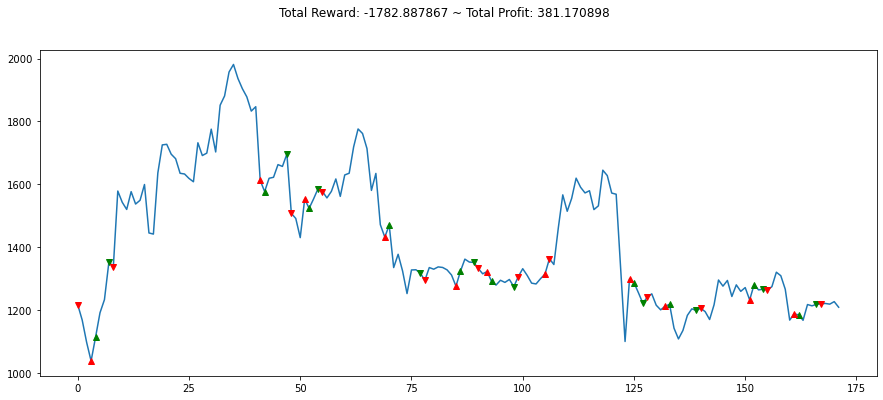

In [86]:
plt.figure(figsize=(15,6))
plt.cla()
env_l.render()


In [84]:
# Test for random n_eval_episodes
max_steps = 20 
env_test_rand = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=True, scaler=env.get_scaler())
n_eval_episodes = 1000

evaluate_agent(env_test_rand, max_steps, n_eval_episodes, model, random=True)

(-156.66986416870117,
 394.94783990529805,
 4.957175903320312,
 211.59187866264426)

In [85]:
# trade sequentially with random actions 
max_steps = len(eth_test)
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=False, scaler=env.get_scaler())
n_eval_episodes = 1

all_profit=[]
for i in range(1000):
    _,_,profit,_=evaluate_agent(env_test, max_steps, n_eval_episodes, model, random=True)
    all_profit.append(profit)
print(f"Mean profit {np.mean(all_profit)}")

Mean profit 3.7792178955078124


## Results

| Model      | 1000 trades 20 steps | Sequential trading | 1000 trades 20 steps random actions | Sequential random|
|------------|----------------------|--------------------|-------------------------------------|------------------|
|Q-learning  | 113.14               | 563.67             | -18.10                              | 39.30            |
|DQN         | 87.62                | 381.17             | 4.95                                | 3.77             |
|Policy Gradi|                      |                    |                                     |                  |


#### Actions are: Buy/Sell/Hold 1 ETH 
1000 trades 20 steps - Made 1000 episodes, 20 trades each episode, result is the mean return of each episode 

Sequential trading (175 days)- Trade the test set sequentially from start to end day 

1000 trades 20 steps random actions - Made 1000 episodes, 20 trades each episode taking random actions 

Sequential random (175 days)- Trade the test set sequentially from start to end day with random actions 